# Introduction
In this notebook, we created the dataset class used to feed slices and corresponding segmentation masks to the network during training.

## Imports

* pathlib for easy path handling
* torch for dataset creation
* numpy for file loading and processing
* imgaug for data augmentation
* matplotlib for demo

In [5]:
from pathlib import Path

import torch
import numpy as np
import imgaug
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage
import matplotlib.pyplot as plt

## DataSet Creation
We implemented the following functionality:
1. Create a list of all 2D slices. To so we need to extract all slices from all subjects
2. Extract the corresponding label path for each slice path
3. Load slice and label
4. Data Augmentation. Make sure that slice and mask are augmented identically. imgaug handles this for us, thus we will not use torchvision.transforms for that
5. Return slice and mask

In [10]:
from pathlib import Path
from torch.utils.data import Dataset
import numpy as np
import torch
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

class LungDataset(Dataset):
    def __init__(self, root, seq=None, base_seed=42):
        """
        root:
          .../Preprocessed_for_2D_Unet/splits/train/fold0/train
          which contains:
            image/Lung_xxx/*.npy
            label_gtvp/Lung_xxx/*.npy
        """
        self.root = Path(root)
        self.seq = seq
        self.base_seed = base_seed
        self.samples = []

        img_root = self.root / "image"
        lbl_root = self.root / "label_gtvp"

        if not img_root.exists():
            raise ValueError(f"Image root not found: {img_root}")

        # Iterate over case folders: Lung_014, Lung_015, ...
        for case_dir in sorted(img_root.iterdir()):
            if not case_dir.is_dir():
                continue
            case_id = case_dir.name
            lbl_case_dir = lbl_root / case_id

            for img_path in sorted(case_dir.glob("*.npy")):
                lbl_path = lbl_case_dir / img_path.name
                if lbl_path.exists():
                    self.samples.append((img_path, lbl_path))
                else:
                    print(f"[WARN] Mask missing for {img_path}")

        print(f"[LungDataset] Found {len(self.samples)} slice pairs in {self.root}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, lbl_path = self.samples[idx]

        img = np.load(img_path).astype(np.float32)  # (H, W)
        msk = np.load(lbl_path).astype(np.int32)    # (H, W)

        # imgaug expects (H, W, C)
        img_3c = img[..., None]
        segmap = SegmentationMapsOnImage(msk, shape=img_3c.shape[:2])

        if self.seq is not None:
            det = self.seq.to_deterministic()
            img_3c = det.augment_image(img_3c)
            segmap = det.augment_segmentation_maps([segmap])[0]
            msk = segmap.get_arr()

        # To torch tensors, (C, H, W)
        img_t = torch.from_numpy(img_3c.transpose(2, 0, 1))  # (1, H, W)
        msk_t = torch.from_numpy(msk[None, ...].astype(np.int64))  # (1, H, W) or class labels

        return img_t, msk_t

Define the data augmentation routine corresponding of scaling and rotation.

In [11]:
seq = iaa.Sequential([
    iaa.Affine(scale=(0.85, 1.15), # zoom in or out
               rotate=(-45, 45)),  # rotate up to 45 degrees
    iaa.ElasticTransformation()
                ])

In [12]:
# Root of the whole project
BASE = Path(r"E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split")

# Root of preprocessed 2D data
PRE_ROOT = BASE / "Preprocessed_for_2D_Unet" / "splits"

# Choose split and fold
split = "train"          # or "val", "test" (for test there is no fold)
fold  = "fold0"          # fold0..fold4

# For CV folds (train/val)
path = PRE_ROOT / "train" / fold / split   # e.g. .../Preprocessed_for_2D_Unet/splits/train/fold0/train

print(f"BASE exists? {BASE.exists()} -> {BASE}")
print(f"path exists? {path.exists()} -> {path}")

# Optional: quick peek at layout
if path.exists():
    img_root = path / "image"
    lbl_root = path / "label_gtvp"

    some_data  = list(img_root.glob("*/*.npy"))[:5]    # case_id / slice.npy
    some_masks = list(lbl_root.glob("*/*.npy"))[:5]

    print("Sample data files:", [p.as_posix() for p in some_data])
    print("Sample mask files:", [p.as_posix() for p in some_masks])

# Instantiate your dataset (LungDataset should expect a root with image/ and label_gtvp/)
dataset = LungDataset(path, seq, base_seed=42)
print("Dataset size:", len(dataset))

BASE exists? True -> E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split
path exists? True -> E:\DoNotTouch\projects\LANSCLC\CIS_5810\selected_150_split\Preprocessed_for_2D_Unet\splits\train\fold0\train
Sample data files: ['E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/image/Lung_014/0.npy', 'E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/image/Lung_014/1.npy', 'E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/image/Lung_014/10.npy', 'E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/image/Lung_014/11.npy', 'E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Unet/splits/train/fold0/train/image/Lung_014/12.npy']
Sample mask files: ['E:/DoNotTouch/projects/LANSCLC/CIS_5810/selected_150_split/Preprocessed_for_2D_Un

Visualize our dataset. To make sure that the augmentation works, we accessed the same element multiple times and checked whether the segmentation masks fit.

In [13]:
list(range(min(len(dataset), 9)))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

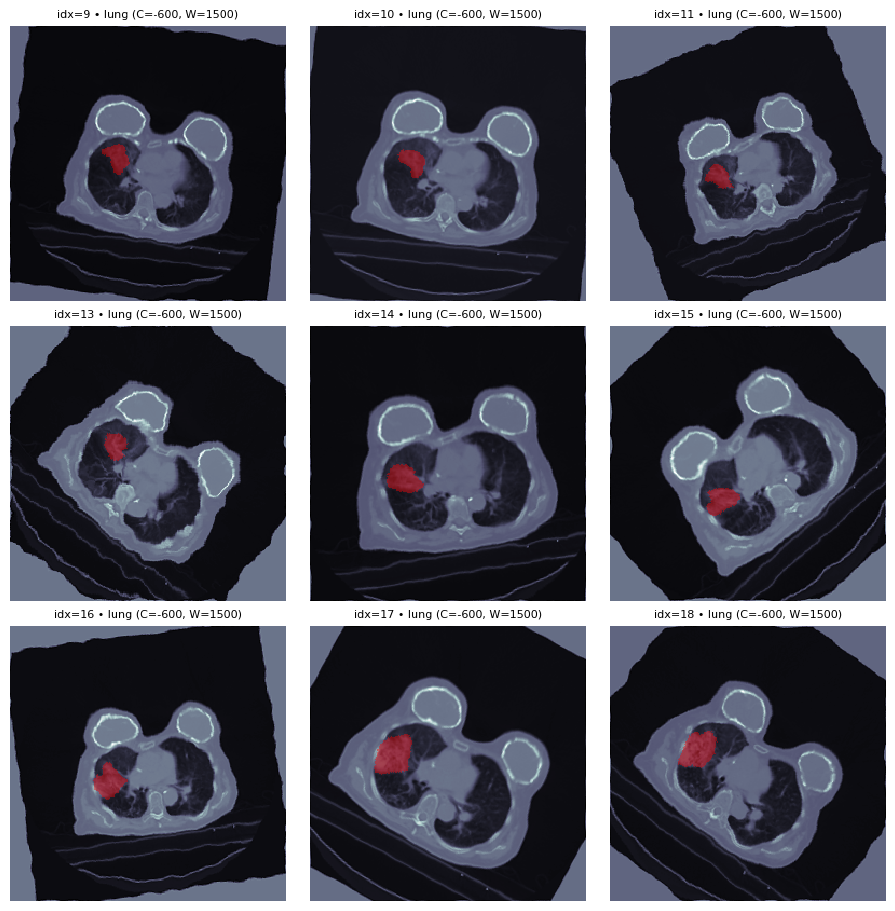

In [14]:
import numpy as np
import matplotlib.pyplot as plt

def reorient_2d(a: np.ndarray) -> np.ndarray:
    # flip vertically, then rotate -90° (clockwise)
    return np.rot90(np.flipud(a), k=3)

def window_hu(img, center, width):
    lo = center - width/2.0
    hi = center + width/2.0
    img = np.nan_to_num(img, nan=lo, posinf=hi, neginf=lo)
    img = np.clip(img, lo, hi)
    return (img - lo) / (hi - lo + 1e-8)  # normalize to [0,1]

# choose a preset
WINDOWS = {
    "lung":        (-600, 1500),
    "mediastinal": (  40,  400),
    "soft_tissue": (  50,  350),
}
preset = "lung"   # <- try "mediastinal" if too bright
C, W = WINDOWS[preset]

# pick first 9 indices with any labeled pixels
idxs = []
for i in range(len(dataset)):
    _, m = dataset[i]               # (1,H,W)
    if np.squeeze(m).max() > 0:     # any label present
        idxs.append(i)
        if len(idxs) == 9:
            break

fig, axes = plt.subplots(3, 3, figsize=(9, 9), constrained_layout=True)
axes = axes.ravel()

for k, ax in enumerate(axes):
    ax.axis("off")
    if k >= len(idxs): continue

    slc, msk = dataset[idxs[k]]     # (1,H,W)
    img2d = np.squeeze(slc)
    m2d   = np.squeeze(msk)

    # reorient
    img_r = reorient_2d(img2d)
    msk_r = reorient_2d(m2d)

    # window using chosen preset (darker than percentile)
    disp = window_hu(img_r, center=C, width=W)

    ax.imshow(disp, cmap="bone", interpolation="none")
    if np.any(msk_r > 0):
        ax.imshow(np.ma.masked_where(msk_r <= 0, msk_r),
                  cmap="autumn", alpha=0.40, interpolation="nearest")
    ax.set_title(f"idx={idxs[k]} • {preset} (C={C}, W={W})", fontsize=8)

plt.show()